# Package installations and imports

In [1]:
%pip install cpi

In [2]:
import numpy as np
import pandas as pd
import re
import datetime
import itertools
%pip install seaborn --upgrade
import seaborn as sns
from matplotlib import pyplot as plt

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.1)


In [3]:
import cpi

/usr/local/lib/python3.6/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [4]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [5]:
from google.colab import drive

drive.mount(r'/content/drive/', force_remount=True)

%cd drive/MyDrive/ColabNotebooks/DataScience/

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1b9TIVx2cU7iqr_Ll_xludM0ScTIaQFfL/DataScience


In [6]:
import warnings
warnings.filterwarnings('ignore')

# Data loading and cleaning

In [7]:
# Open raw data files
file_list = ['./movies_raw_1.json', './movies_raw_2.json', './movies_raw_3.json']

# Load all files into pandas
single_df = (pd.read_json(file) for file in file_list)
data = pd.concat(single_df,ignore_index=True)
data = data.sort_values(by='ratingValue',ascending=False).reset_index(drop=True)

# Replace 'N/A' values with proper 'np.nan' values
data = data.replace('N/A', np.nan)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5225 entries, 0 to 5224
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        5225 non-null   object 
 1   ratingValue  5225 non-null   float64
 2   ratingCount  5225 non-null   int64  
 3   year         5225 non-null   int64  
 4   budget       3852 non-null   object 
 5   gross        4651 non-null   object 
 6   country      5225 non-null   object 
 7   name         5225 non-null   object 
 8   tomatoMeter  3986 non-null   float64
 9   runtime      5186 non-null   float64
 10  genres       5225 non-null   object 
 11  Director:    4849 non-null   object 
 12  Writers:     3813 non-null   object 
 13  Stars:       5224 non-null   object 
 14  Directors:   376 non-null    object 
 15  Writer:      1410 non-null   object 
dtypes: float64(3), int64(2), object(11)
memory usage: 653.2+ KB


,title,ratingValue,ratingCount,year,budget,gross,country,name,tomatoMeter,runtime,genres,Director:,Writers:,Stars:,Directors:,Writer:
0,Hababam Sinifi (1975) - IMDb,9.3,36953,1975,NaN,NaN,Turkey,Hababam Sinifi,NaN,87.0,"[Comedy, Drama]","[{'link': '/name/nm0251027/', 'name': 'Ertem E...","[{'link': '/name/nm0119457/', 'name': 'Umur Bu...","[{'link': '/name/nm0839017/', 'name': 'Kemal S...",NaN,NaN
1,The Shawshank Redemption (1994) - IMDb,9.3,2325052,1994,"$25,000,000","$28,817,291",USA,The Shawshank Redemption,91.0,142.0,[Drama],"[{'link': '/name/nm0001104/', 'name': 'Frank D...","[{'link': '/name/nm0000175/', 'name': 'Stephen...","[{'link': '/name/nm0000209/', 'name': 'Tim Rob...",NaN,NaN
2,The Godfather (1972) - IMDb,9.2,1606347,1972,"$6,000,000","$246,120,986",USA,The Godfather,98.0,175.0,"[Crime, Drama]","[{'link': '/name/nm0000338/', 'name': 'Francis...","[{'link': '/name/nm0701374/', 'name': 'Mario P...","[{'link': '/name/nm0000008/', 'name': 'Marlon ...",NaN,NaN
3,Tosun Pasa (1976) - IMDb,9.0,21395,1976,NaN,NaN,Turkey,Tosun Pasa,NaN,90.0,"[Comedy, History]","[{'link': '/name/nm0862605/', 'name': 'Kartal ...","[{'link': '/name/nm0383740/', 'name': 'Nazim H...","[{'link': '/name/nm0839017/', 'name': 'Kemal S...",NaN,NaN
4,The Chaos Class Failed the Class (1976) - IMDb,9.0,21611,1976,NaN,NaN,Turkey,The Chaos Class Failed the Class,NaN,91.0,[Comedy],"[{'link': '/name/nm0251027/', 'name': 'Ertem E...","[{'link': '/name/nm0407642/', 'name': 'Rifat I...","[{'link': '/name/nm0839017/', 'name': 'Kemal S...",NaN,NaN


In [8]:
# Drop redundant column 'title'
data1 = data.drop(columns=['title'])

# Rearrange columns
new_columns = ['name', 'year', 'country', 'genres', 'runtime',
               'ratingValue', 'ratingCount', 'tomatoMeter',
               'budget', 'gross',
               'Director:', 'Directors:', 'Writer:', 'Writers:',
               'Stars:']

data2 = data1[new_columns]

In [9]:
# Merge 'Director:' and 'Directors:' columns
directors_dict = {}
writers_dict = {}

def merge_director(row):
  merged_directors = []

  if (row['Director:'] is not np.nan):
    # Iterate through list of directors
    for director in row['Director:']:
      # Filter out invalid director entries
      if director['name'].find(" more ") is -1:
        # To differentiate between directors,
        # use the number part of the link
        director_id = re.search(r"(\d+)", director['link']).group(0)
        directors_dict[director_id] = (director['name'],0,0,0)
        # Insert this entry into dictionary
        merged_directors.append(director_id)

  # Do the same thing for 'Directors:' column
  if (row['Directors:'] is not np.nan):
    for director in row['Directors:']:
        if director['name'].find(" more ") is -1:
          director_id = re.search(r"(\d+)", director['link']).group(0)
          directors_dict[director_id] = (director['name'],0,0,0)
          merged_directors.append(director_id)

  return merged_directors

# Merge 'Writer:' and 'Writers:' columns
def merge_writer(row):
  merged_writers = []

  if (row['Writer:'] is not np.nan):
    for writer in row['Writer:']:
      if writer['name'].find(" more ") is -1:
        writer_id = re.search(r"(\d+)", writer['link']).group(0)
        writers_dict[writer_id] = (writer['name'],0,0,0)
        merged_writers.append(writer_id)

  if (row['Writers:'] is not np.nan):
    for writer in row['Writers:']:
      if writer['name'].find(" more ") is -1:
        writer_id = re.search(r"(\d+)", writer['link']).group(0)
        #merged_writers[writer_id] = writer['name']
        writers_dict[writer_id] = (writer['name'],0,0,0)
        merged_writers.append(writer_id)

  return merged_writers


# Apply merging routine on data
director_col_cleaned = data2[['Director:', 'Directors:']].apply(
    merge_director,
    axis=1
)

writer_col_cleaned = data2[['Writer:', 'Writers:']].apply(
    merge_writer,
    axis=1
)

# Drop consumed columns
data3 = data2.drop(columns=['Directors:', 'Director:', 'Writers:', 'Writer:'])

# Update data
data3['directors'] = director_col_cleaned
data3['writers'] = writer_col_cleaned

data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5225 entries, 0 to 5224
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         5225 non-null   object 
 1   year         5225 non-null   int64  
 2   country      5225 non-null   object 
 3   genres       5225 non-null   object 
 4   runtime      5186 non-null   float64
 5   ratingValue  5225 non-null   float64
 6   ratingCount  5225 non-null   int64  
 7   tomatoMeter  3986 non-null   float64
 8   budget       3852 non-null   object 
 9   gross        4651 non-null   object 
 10  Stars:       5224 non-null   object 
 11  directors    5225 non-null   object 
 12  writers      5225 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 530.8+ KB


,name,year,country,genres,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,Stars:,directors,writers
0,Hababam Sinifi,1975,Turkey,"[Comedy, Drama]",87.0,9.3,36953,NaN,NaN,NaN,"[{'link': '/name/nm0839017/', 'name': 'Kemal S...",[0251027],"[0119457, 0407642]"
1,The Shawshank Redemption,1994,USA,[Drama],142.0,9.3,2325052,91.0,"$25,000,000","$28,817,291","[{'link': '/name/nm0000209/', 'name': 'Tim Rob...",[0001104],"[0000175, 0001104]"
2,The Godfather,1972,USA,"[Crime, Drama]",175.0,9.2,1606347,98.0,"$6,000,000","$246,120,986","[{'link': '/name/nm0000008/', 'name': 'Marlon ...",[0000338],"[0701374, 0000338]"
3,Tosun Pasa,1976,Turkey,"[Comedy, History]",90.0,9.0,21395,NaN,NaN,NaN,"[{'link': '/name/nm0839017/', 'name': 'Kemal S...",[0862605],"[0383740, 0877078]"
4,The Chaos Class Failed the Class,1976,Turkey,[Comedy],91.0,9.0,21611,NaN,NaN,NaN,"[{'link': '/name/nm0839017/', 'name': 'Kemal S...",[0251027],"[0407642, 0784149]"


In [10]:
# Drop Nan values on 'Stars:' column
data4 = data3.loc[data3["Stars:"].notna()]

# Reshape 'Stars:' column
stars_dict = {}

def clean_stars(row):
  # Filter out invalid entries
  if row['Stars:'][-1]['name'].find('See f') is not -1:
    row['Stars:'].pop(-1)
  
  # Cut out the number part of the link and
  # use it as an id
  stars_id = []
  for star in row['Stars:']:
    star_id = re.search(r"(\d+)", star['link']).group(0)
    #stars[star_id] = star["name"]
    stars_dict[star_id] = (star["name"],0,0,0)
    stars_id.append(star_id)
  return stars_id

# Apply cleaning routine
star_col_cleaned = data4[['Stars:']].apply(
    clean_stars,
    axis=1
)

# Drop consumed column
data4 = data4.drop(columns=['Stars:'])

# Update data
data4['stars'] = star_col_cleaned

data4.info()
data4.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5224 entries, 0 to 5224
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         5224 non-null   object 
 1   year         5224 non-null   int64  
 2   country      5224 non-null   object 
 3   genres       5224 non-null   object 
 4   runtime      5185 non-null   float64
 5   ratingValue  5224 non-null   float64
 6   ratingCount  5224 non-null   int64  
 7   tomatoMeter  3985 non-null   float64
 8   budget       3852 non-null   object 
 9   gross        4651 non-null   object 
 10  directors    5224 non-null   object 
 11  writers      5224 non-null   object 
 12  stars        5224 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 571.4+ KB


,name,year,country,genres,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,directors,writers,stars
0,Hababam Sinifi,1975,Turkey,"[Comedy, Drama]",87.0,9.3,36953,NaN,NaN,NaN,[0251027],"[0119457, 0407642]","[0839017, 0654805, 0015145]"
1,The Shawshank Redemption,1994,USA,[Drama],142.0,9.3,2325052,91.0,"$25,000,000","$28,817,291",[0001104],"[0000175, 0001104]","[0000209, 0000151, 0348409]"
2,The Godfather,1972,USA,"[Crime, Drama]",175.0,9.2,1606347,98.0,"$6,000,000","$246,120,986",[0000338],"[0701374, 0000338]","[0000008, 0000199, 0001001]"
3,Tosun Pasa,1976,Turkey,"[Comedy, History]",90.0,9.0,21395,NaN,NaN,NaN,[0862605],"[0383740, 0877078]","[0839017, 0032661, 0621870]"
4,The Chaos Class Failed the Class,1976,Turkey,[Comedy],91.0,9.0,21611,NaN,NaN,NaN,[0251027],"[0407642, 0784149]","[0839017, 0654805, 0654744]"


In [11]:
# Clean 'budget' and 'gross' columns
data5 = data4.loc[data4["budget"].notna() & data4["gross"].notna()]

# Filter out non USD values
filter = [True] * len(data5['budget'])
years = data5['year']

for index, entry in enumerate(data5['budget']):
  if entry.startswith('$'):
    pass
  else:
    filter[index] = False

data5 = data5.loc[filter]

# Convert currency representation into actual value
# De-inflation
def deinflate_usd(row):
  year = row['year']

  budget = locale.atoi(row['budget'][1:])
  gross = locale.atoi(row['gross'][1:])
  if row['year'] <= 2018:
    budget = int(cpi.inflate(budget, year))
    gross = int(cpi.inflate(gross, year))

  return pd.Series([budget, gross])

new_values = data5[['budget', 'gross', 'year']].apply(deinflate_usd, axis=1)
data5[['budget', 'gross']] = new_values

data_semi_cleaned = data5

data_semi_cleaned.info()
data_semi_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 1 to 5224
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         3291 non-null   object 
 1   year         3291 non-null   int64  
 2   country      3291 non-null   object 
 3   genres       3291 non-null   object 
 4   runtime      3278 non-null   float64
 5   ratingValue  3291 non-null   float64
 6   ratingCount  3291 non-null   int64  
 7   tomatoMeter  2805 non-null   float64
 8   budget       3291 non-null   int64  
 9   gross        3291 non-null   int64  
 10  directors    3291 non-null   object 
 11  writers      3291 non-null   object 
 12  stars        3291 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 360.0+ KB


,name,year,country,genres,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,directors,writers,stars
1,The Shawshank Redemption,1994,USA,[Drama],142.0,9.3,2325052,91.0,42359480,48827418,[0001104],"[0000175, 0001104]","[0000209, 0000151, 0348409]"
2,The Godfather,1972,USA,"[Crime, Drama]",175.0,9.2,1606347,98.0,36044066,1478533550,[0000338],"[0701374, 0000338]","[0000008, 0000199, 0001001]"
5,The Dark Knight,2008,USA,"[Action, Crime, Drama, Thriller]",152.0,9.0,2284419,94.0,215764736,1173262908,[0634240],"[0634300, 0634240]","[0000288, 0005132, 0001173]"
6,12 Angry Men,1957,USA,"[Crime, Drama]",96.0,9.0,683527,100.0,3127667,5147,[0001486],"[0741627, 0741627]","[0000020, 0002011, 0000842]"
10,The Lord of the Rings: The Return of the King,2003,New Zealand,"[Action, Adventure, Drama, Fantasy]",201.0,8.9,1631879,93.0,128282923,1559124709,[0001392],"[0866058, 0909638]","[0000704, 0001557, 0005212]"


Clean numerical data

In [12]:
data_num = data_semi_cleaned

data_num = data_num.select_dtypes(include = ['float64', 'int64'])

# Introduce new column 'profit_percentage'
data_num['profit_percentage'] = \
  (data_num['gross'] - data_num['budget'])*100/ \
   data_num['budget']

data_num.info()
data_num.head()                 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 1 to 5224
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               3291 non-null   int64  
 1   runtime            3278 non-null   float64
 2   ratingValue        3291 non-null   float64
 3   ratingCount        3291 non-null   int64  
 4   tomatoMeter        2805 non-null   float64
 5   budget             3291 non-null   int64  
 6   gross              3291 non-null   int64  
 7   profit_percentage  3291 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 231.4 KB


,year,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,profit_percentage
1,1994,142.0,9.3,2325052,91.0,42359480,48827418,15.269163
2,1972,175.0,9.2,1606347,98.0,36044066,1478533550,4002.016543
5,2008,152.0,9.0,2284419,94.0,215764736,1173262908,443.769538
6,1957,96.0,9.0,683527,100.0,3127667,5147,-99.835436
10,2003,201.0,8.9,1631879,93.0,128282923,1559124709,1115.379781


Clean categorical data

In [13]:
# Select categorical data columns
data_cat = data_semi_cleaned.select_dtypes(include=['object'])

# EDA on numerical data

In [14]:
data_num.head()

,year,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,profit_percentage
1,1994,142.0,9.3,2325052,91.0,42359480,48827418,15.269163
2,1972,175.0,9.2,1606347,98.0,36044066,1478533550,4002.016543
5,2008,152.0,9.0,2284419,94.0,215764736,1173262908,443.769538
6,1957,96.0,9.0,683527,100.0,3127667,5147,-99.835436
10,2003,201.0,8.9,1631879,93.0,128282923,1559124709,1115.379781


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61f1be77f0>,
      dtype=object)

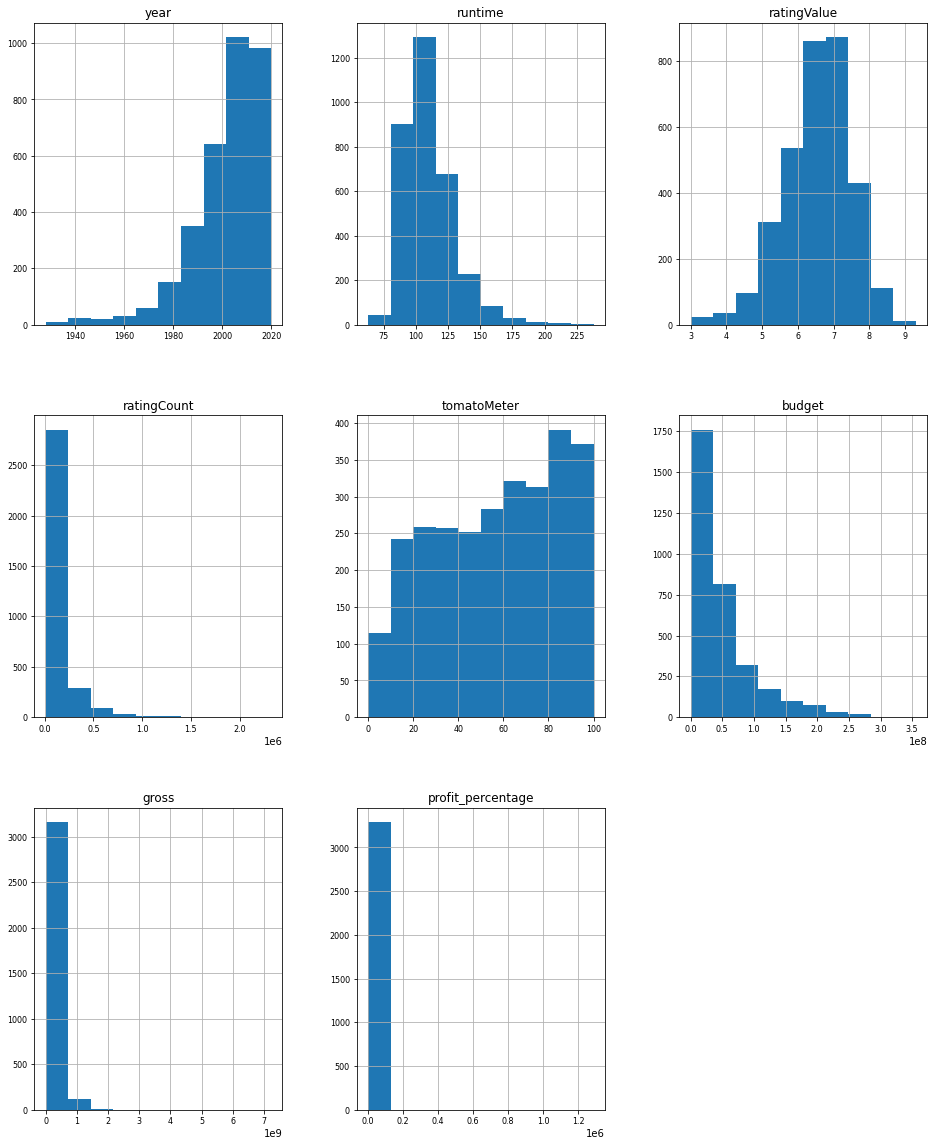

In [15]:
data_num.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8)

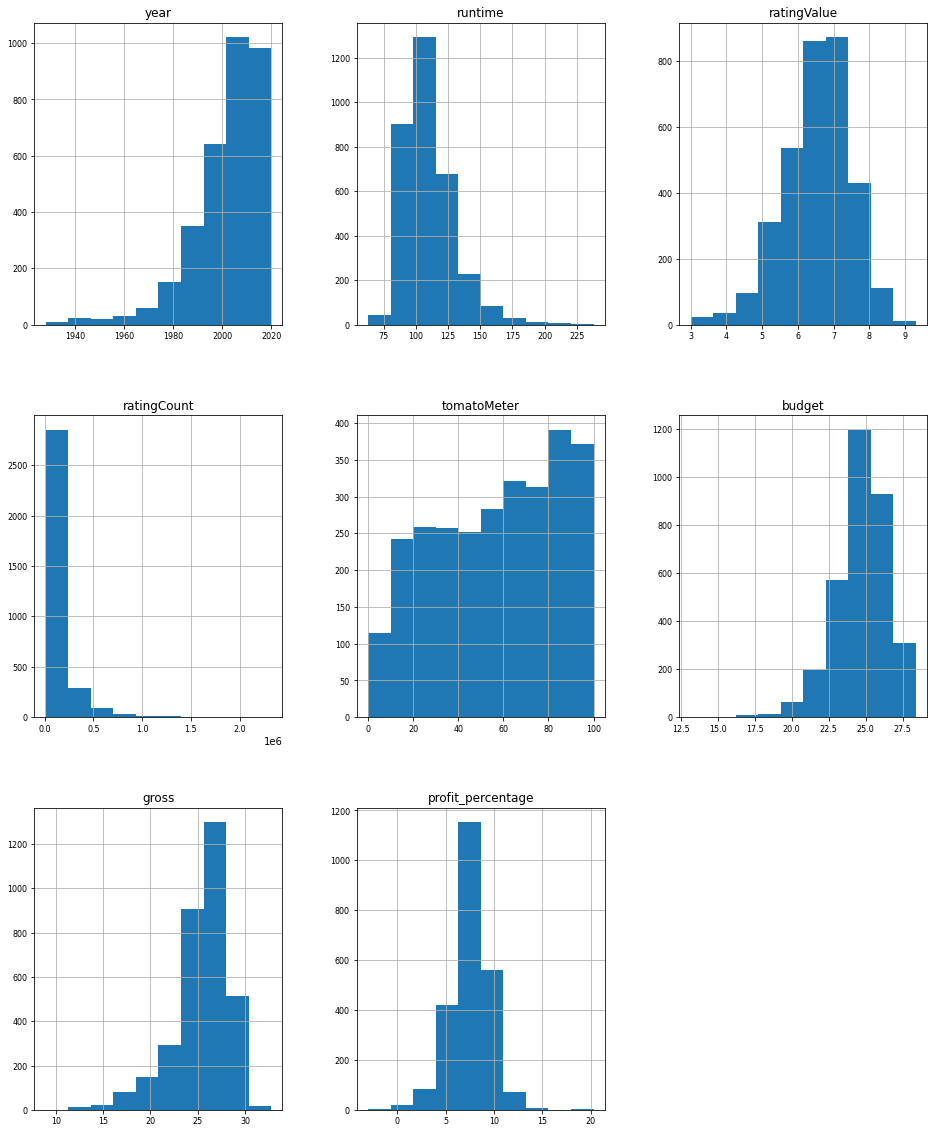

In [16]:
# Try to change gross and budget column to log
df = data_num

lambda_log = lambda row: np.log2(row)

df[['gross', 'budget', 'profit_percentage']] = \
df[['gross', 'budget', 'profit_percentage']].apply(lambda_log)

df.head()
hist = df.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8)


In [17]:
# describle each column of the modified-dataframe
data_num.describe()

,year,runtime,ratingValue,ratingCount,tomatoMeter,budget,gross,profit_percentage
count,3291.000000,3278.000000,3291.000000,3.291000e+03,2805.000000,3291.000000,3291.000000,2321.000000
mean,2001.950471,109.852349,6.547524,1.228887e+05,56.303387,24.733724,25.430419,7.552916
std,13.929402,19.816079,0.941822,1.831433e+05,27.493008,1.760055,2.937480,2.021553
min,1928.000000,63.000000,3.000000,1.000100e+04,0.000000,13.174145,8.933691,-3.038617
25%,1996.000000,96.000000,6.000000,2.592350e+04,33.000000,23.792821,24.198525,6.449460
50%,2005.000000,106.000000,6.600000,5.790800e+04,59.000000,24.973936,25.937964,7.667911
75%,2012.000000,119.000000,7.200000,1.405275e+05,81.000000,25.921771,27.350393,8.754399
max,2020.000000,238.000000,9.300000,2.325052e+06,100.000000,28.407302,32.751207,20.297764


pearson correlation heatmap



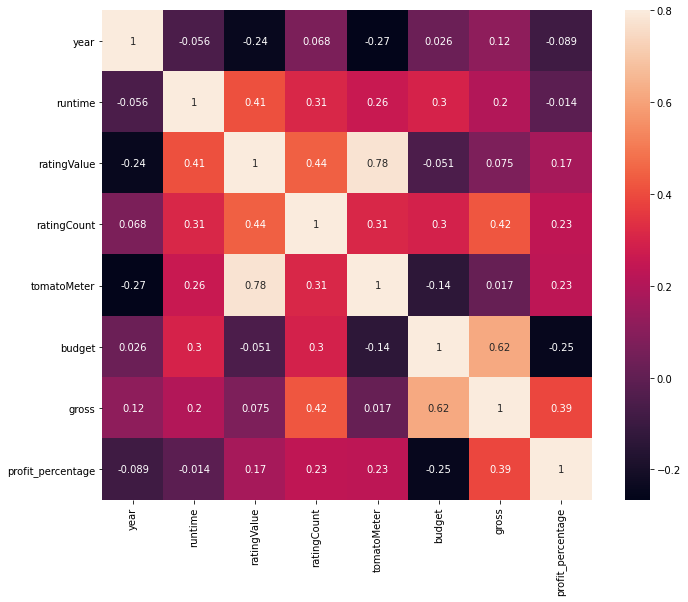

spearman correlation heatmap



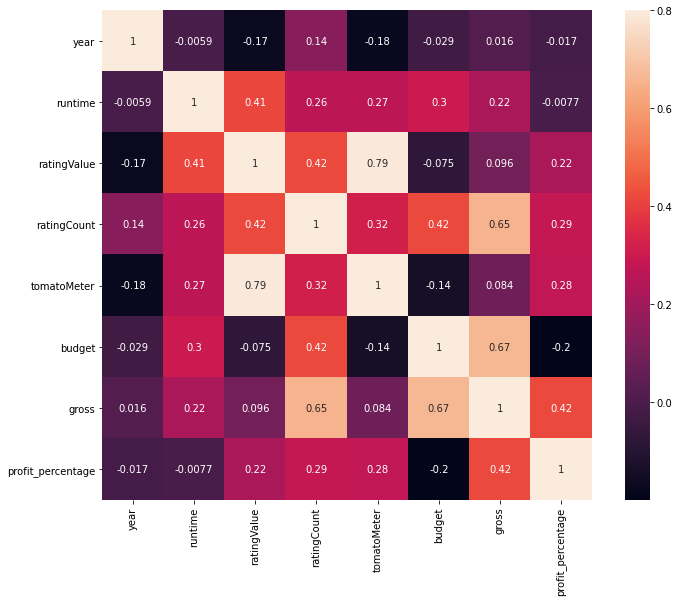

In [18]:
# Display correlation matrix
def print_heatmap(cor_method):
  corrmat = data_num.corr(method=cor_method)
  print("{} correlation heatmap\n".format(cor_method))
  f, ax = plt.subplots(figsize=(12, 9))
  sns.heatmap(corrmat,annot= True, vmax=.8, square=True)
  plt.show()
print_heatmap('pearson')
print_heatmap('spearman')

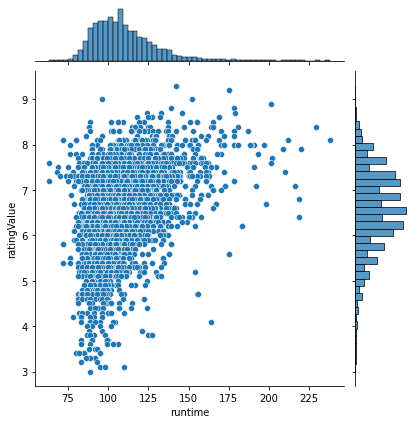

good spearman correlation of column ['runtime'] and ['ratingValue'] is 0.41387115093228494


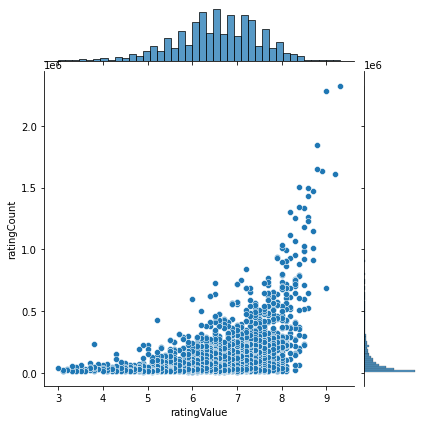

good spearman correlation of column ['ratingValue'] and ['ratingCount'] is 0.41910508606667907


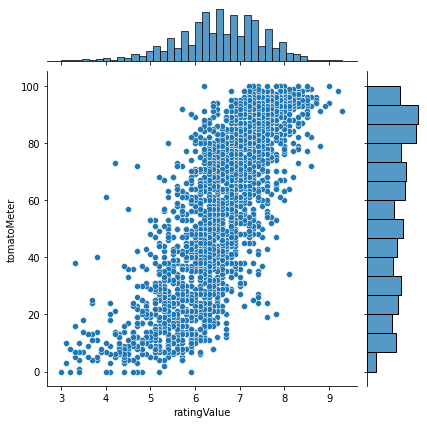

good spearman correlation of column ['ratingValue'] and ['tomatoMeter'] is 0.794139188454784


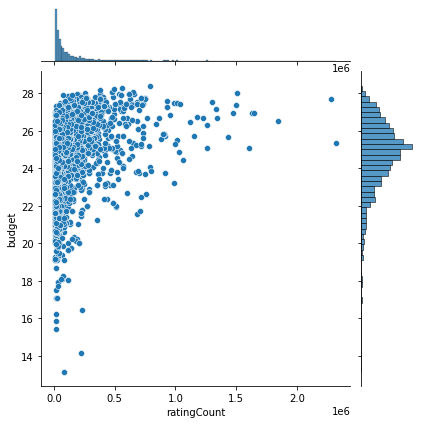

good spearman correlation of column ['ratingCount'] and ['budget'] is 0.4206324493005103


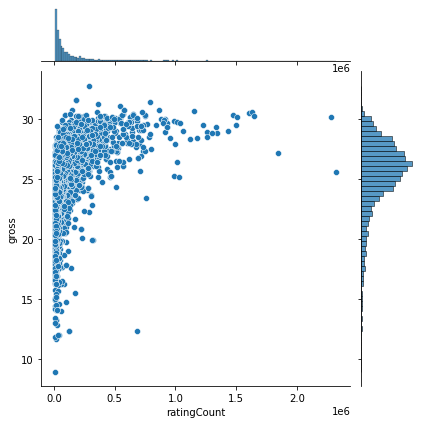

good spearman correlation of column ['ratingCount'] and ['gross'] is 0.6521417469357981


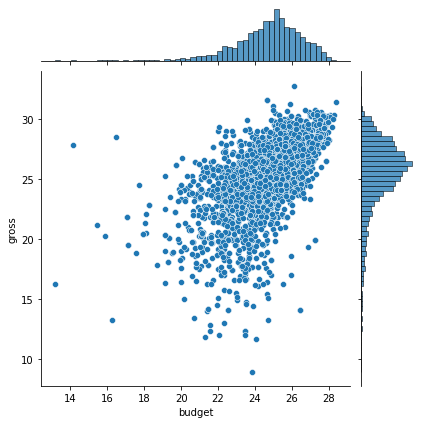

good spearman correlation of column ['budget'] and ['gross'] is 0.6670074929201214


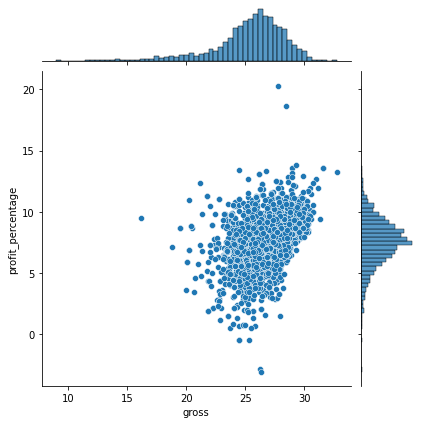

good spearman correlation of column ['gross'] and ['profit_percentage'] is 0.41761808691105684


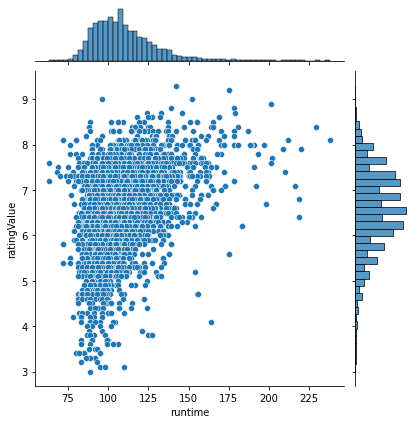

good pearson correlation of column ['runtime'] and ['ratingValue'] is 0.4088775323164597


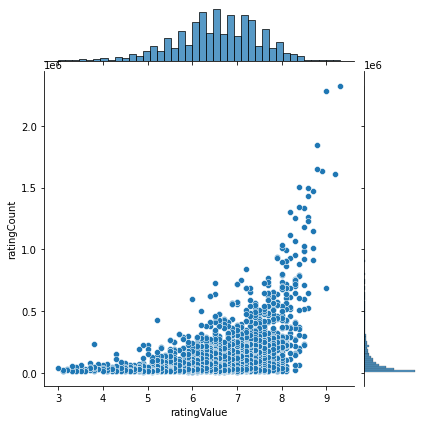

good pearson correlation of column ['ratingValue'] and ['ratingCount'] is 0.444736430228156


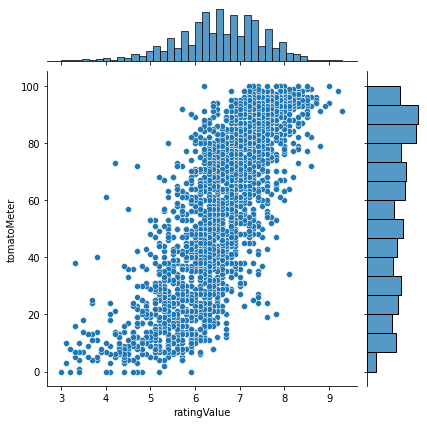

good pearson correlation of column ['ratingValue'] and ['tomatoMeter'] is 0.7775909622027481


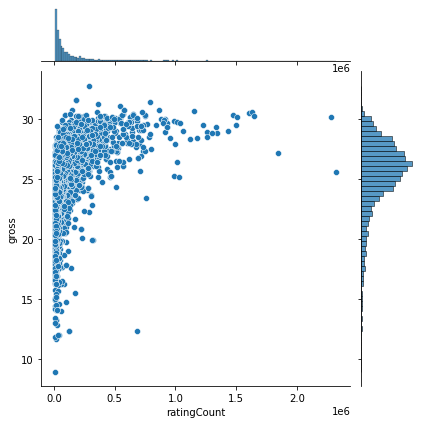

good pearson correlation of column ['ratingCount'] and ['gross'] is 0.4224470055410711


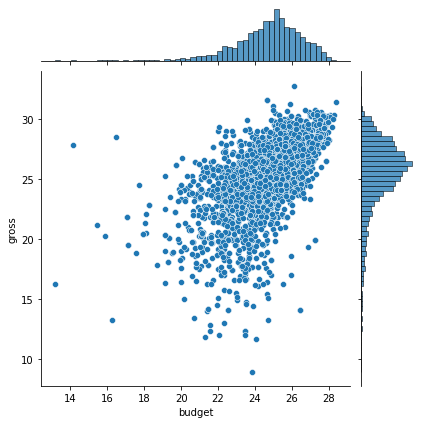

good pearson correlation of column ['budget'] and ['gross'] is 0.6172764890076925


In [19]:
# Pairplot pair of column with good correlation efficiency
def good_correlation_plot(cor_method, good_ratio):
  data_num_corr = data_num.corr(method = cor_method) # choose method
  col_list = []
  for x in data_num_corr:
    col_list.append(x)
    for y in data_num_corr:
      if x != y: 
        if not (y in col_list):
          if abs(data_num_corr[x][y]) > good_ratio: # good ratio depends on the method
            sns.jointplot(
                  x=data_num[x], 
                  y=data_num[y]
                  )
            plt.show()
            print("good {} correlation of column [\'{}\'] and [\'{}\'] is {}".format(cor_method,x,y,data_num_corr[x][y]))
good_correlation_plot('spearman', 0.4)
good_correlation_plot('pearson', 0.4)

In [20]:
import math
#calculate the correlation of a dependent variable with two other independent variables
def calculateR2(x, y, z, cor):
  # Pairings
  xz = cor.loc[ x, z ]
  yz = cor.loc[ y, z ]
  xy = cor.loc[ x, y ]
  Rxyz = math.sqrt((abs(xz**2) + abs(yz**2) - 2*xz*yz*xy) / (1-abs(xy**2)) )
  R2 = Rxyz**2
  print("R2 correlation of [\'{}\'] and [\'{}\'] with dependent column [\'{}\'] is {}\n".format(x,y,z,R2))
  # Calculate adjusted R-squared
  n = len(data_num) # Number of rows
  k = 2       # Number of independent variables
  R2_adj = 1 - ( ((1-R2)*(n-1)) / (n-k-1) )
  print("Adjusted R2 correlation of [\'{}\'] and [\'{}\'] with dependent column [\'{}\'] is {}\n".format(x,y,z,R2_adj))
cor = data_num.corr()
# Independent variables
x = 'gross'
y = 'budget'
# Dependent variable
z = 'ratingValue'
calculateR2(x,y,z,cor)

R2 correlation of ['gross'] and ['budget'] with dependent column ['ratingValue'] is 0.0209822654341432

Adjusted R2 correlation of ['gross'] and ['budget'] with dependent column ['ratingValue'] is 0.020386755863239348



# EDA on categorical data

Calculate average 'ratingValue'/'gross' values over each director, writer and star

In [21]:
def calculate_frequency(row):
  for director in row['directors']:
    directors_dict[director] = (directors_dict[director][0],directors_dict[director][1]+1,directors_dict[director][2]+row['ratingValue'],directors_dict[director][3]+row['gross'])
  for star in row['stars']:
    stars_dict[star] = (stars_dict[star][0],stars_dict[star][1]+1,stars_dict[star][2]+row['ratingValue'],stars_dict[star][3]+row['gross'])
  for writer in row['writers']:
    writers_dict[writer] = (writers_dict[writer][0],writers_dict[writer][1]+1,writers_dict[writer][2]+row['ratingValue'],writers_dict[writer][3]+ row['gross'])

  return row

data_semi_cleaned[['directors','stars','writers','ratingValue','gross']] \
  .apply(calculate_frequency, axis=1)

,directors,stars,writers,ratingValue,gross
1,[0001104],"[0000209, 0000151, 0348409]","[0000175, 0001104]",9.3,48827418
2,[0000338],"[0000008, 0000199, 0001001]","[0701374, 0000338]",9.2,1478533550
5,[0634240],"[0000288, 0005132, 0001173]","[0634300, 0634240]",9.0,1173262908
6,[0001486],"[0000020, 0002011, 0000842]","[0741627, 0741627]",9.0,5147
10,[0001392],"[0000704, 0001557, 0005212]","[0866058, 0909638]",8.9,1559124709
...,...,...,...,...,...
5218,"[0294997, 0783536]","[2118666, 2301213, 2421367]","[0294997, 0783536]",3.2,4210653
5220,[0093051],"[0001709, 0891275, 0992883]","[1178069, 1396574]",3.1,913793
5221,[0573732],"[0795981, 0663546, 2503064]","[0418070, 1089476]",3.1,31503915
5223,[0001532],"[0005098, 0000606, 0005112]","[0365938, 0365938]",3.1,36085658


Calculate values for directors

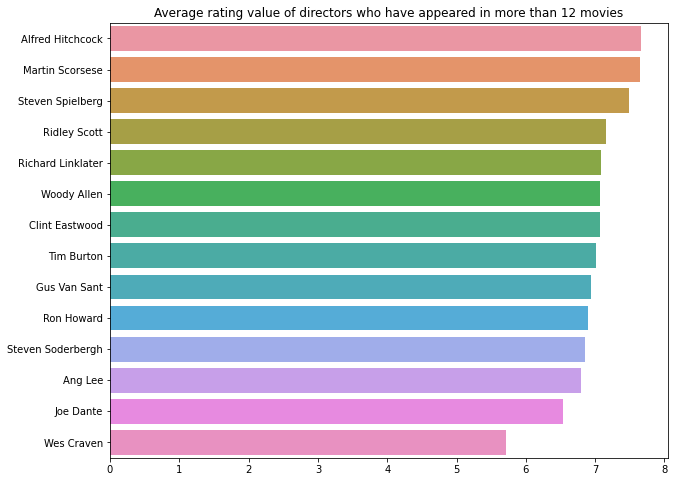

In [22]:
director_rating = {}
for director in directors_dict:
  if directors_dict[director][1] >= 12:
    director_rating[directors_dict[director][0]] = directors_dict[director][2]/directors_dict[director][1]

director_rating = dict(sorted(director_rating.items(), key=lambda item: item[1],reverse=True))
keys = list(director_rating.keys())
vals = [float(director_rating[k]) for k in keys]


fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(y=keys,x= vals,orient = "h").set_title("Average rating value of directors who have appeared in more than 12 movies")


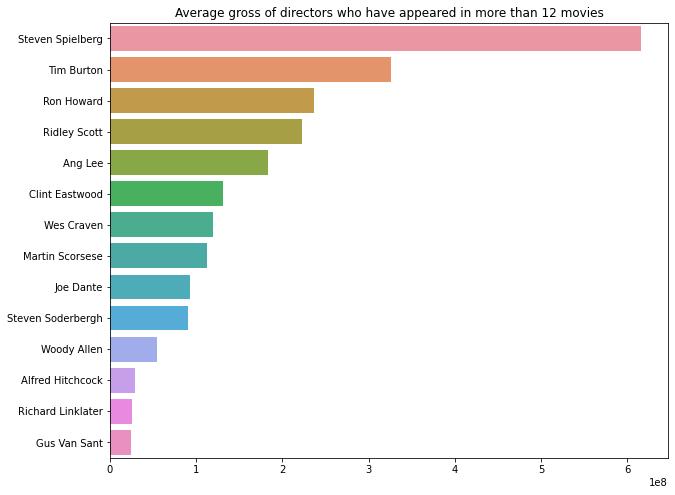

In [23]:
director_gross = {}
for director in directors_dict:
  if directors_dict[director][1] >= 12:
    director_gross[directors_dict[director][0]] = directors_dict[director][3]/directors_dict[director][1]

director_gross = dict(sorted(director_gross.items(), key=lambda item: item[1],reverse=True))
keys = list(director_gross.keys())
vals = [float(director_gross[k]) for k in keys]


fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(y=keys,x= vals,orient = "h").set_title("Average gross of directors who have appeared in more than 12 movies")

Calculate values for stars

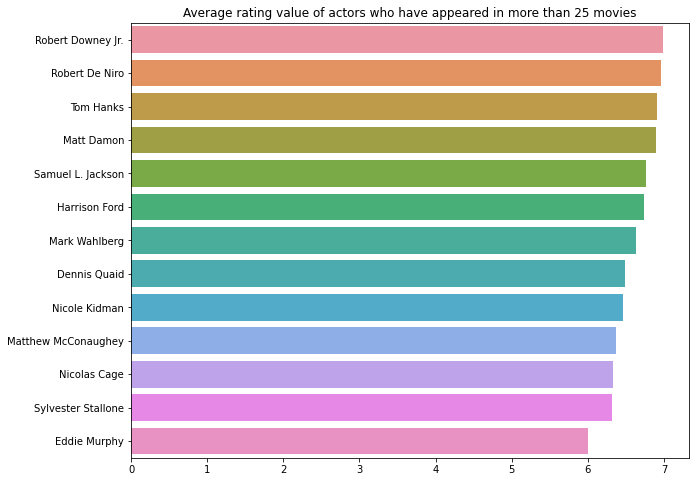

In [24]:
star_rating = {}
for star in stars_dict:
  if stars_dict[star][1] >= 25:
    star_rating[stars_dict[star][0]] = stars_dict[star][2]/stars_dict[star][1]

star_rating = dict(sorted(star_rating.items(), key=lambda item: item[1],reverse=True))
keys = list(star_rating.keys())
vals = [float(star_rating[k]) for k in keys]

fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(y=keys,x= vals,orient = "h",label = "Stars").set_title("Average rating value of actors who have appeared in more than 25 movies")

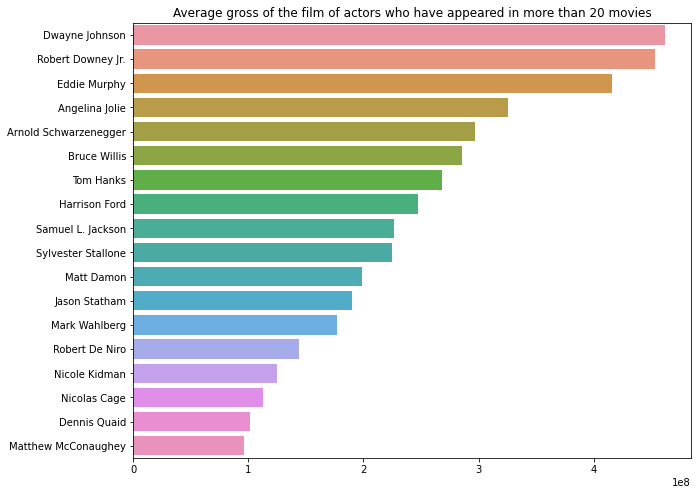

In [25]:
star_gross = {}
for star in stars_dict:
  if stars_dict[star][1] >= 23:
    star_gross[stars_dict[star][0]] = stars_dict[star][3]/stars_dict[star][1]

star_gross = dict(sorted(star_gross.items(), key=lambda item: item[1],reverse=True))
keys = list(star_gross.keys())
vals = [float(star_gross[k]) for k in keys]


fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(y=keys,x= vals,orient = "h").set_title("Average gross of the film of actors who have appeared in more than 20 movies")

Calculate values for writers

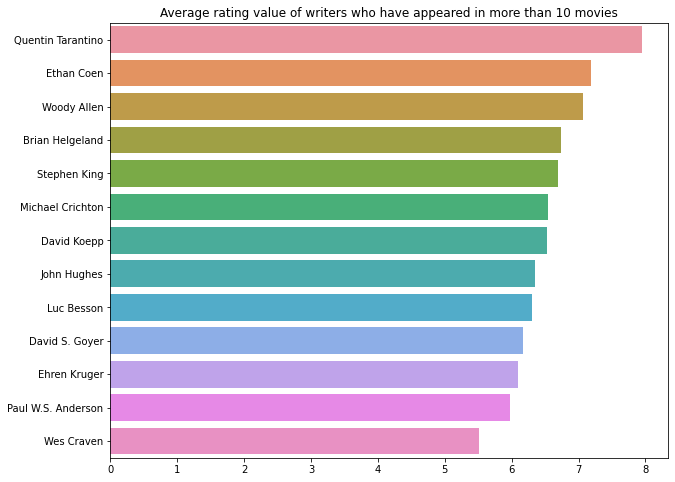

In [26]:
writer_rating = {}
for writer in writers_dict:
  if writers_dict[writer][1] >= 10:
    writer_rating[writers_dict[writer][0]] = writers_dict[writer][2]/writers_dict[writer][1]

writer_rating = dict(sorted(writer_rating.items(), key=lambda item: item[1],reverse=True))
keys = list(writer_rating.keys())
vals = [float(writer_rating[k]) for k in keys]


fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(y=keys,x= vals,orient = "h").set_title("Average rating value of writers who have appeared in more than 10 movies")

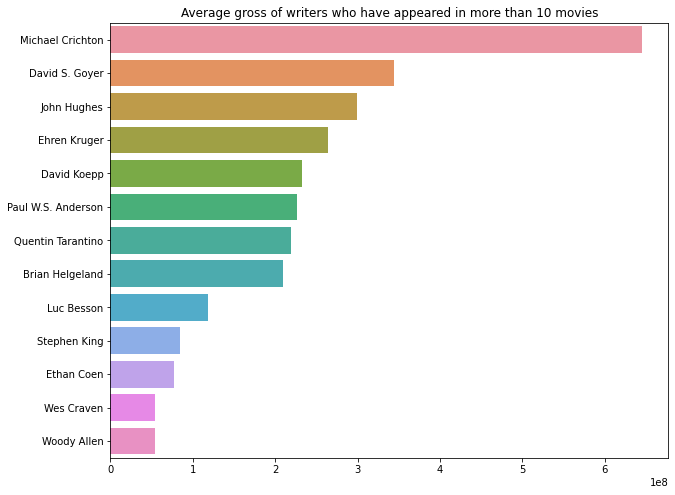

In [27]:
writer_gross = {}
for writer in writers_dict:
  if writers_dict[writer][1] >= 10:
    writer_gross[writers_dict[writer][0]] = writers_dict[writer][3]/writers_dict[writer][1]

writer_gross = dict(sorted(writer_gross.items(), key=lambda item: item[1],reverse=True))
keys = list(writer_gross.keys())
vals = [float(writer_gross[k]) for k in keys]


fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(y=keys,x= vals,orient = "h").set_title("Average gross of writers who have appeared in more than 10 movies")

Explore correlation between **genre** and **rating**

In [28]:
# Helper function for calculating correlation ratio
def correlation_ratio(categories, measurements):
  fcat, _ = pd.factorize(categories)
  cat_num = np.max(fcat)+1
  y_avg_array = np.zeros(cat_num)
  n_array = np.zeros(cat_num)
  for i in range(0,cat_num):
    cat_measures = measurements[fcat == i]
    n_array[i] = len(cat_measures)
    y_avg_array[i] = np.average(cat_measures)

  y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
  numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
  denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
  if numerator == 0:
    eta = 0.0
  else:
    eta = numerator/denominator
  return eta

In [29]:
# Construct a data frame with 'genres' and 'ratingValue'
genre_sub_frame = data5[['genres', 'ratingValue']]

print(genre_sub_frame)

# Split each row containing multiple 'genres' into multiple rows
genre_sub_frame = genre_sub_frame \
    .apply(lambda row: row.explode()) \
    .reset_index()

print(genre_sub_frame)

                                   genres  ratingValue
1                                 [Drama]          9.3
2                          [Crime, Drama]          9.2
5        [Action, Crime, Drama, Thriller]          9.0
6                          [Crime, Drama]          9.0
10    [Action, Adventure, Drama, Fantasy]          8.9
...                                   ...          ...
5218                     [Comedy, Sci-Fi]          3.2
5220          [Action, Adventure, Sci-Fi]          3.1
5221              [Comedy, Family, Music]          3.1
5223              [Action, Sci-Fi, Sport]          3.1
5224        [Adventure, Horror, Thriller]          3.0

[3291 rows x 2 columns]
       index     genres  ratingValue
0          1      Drama          9.3
1          2      Crime          9.2
2          2      Drama          9.2
3          5     Action          9.0
4          5      Crime          9.0
...      ...        ...          ...
10297   5223     Sci-Fi          3.1
10298   5223      S

[Text(0, 0.5, 'genre group'), Text(0.5, 0, 'occurences')]

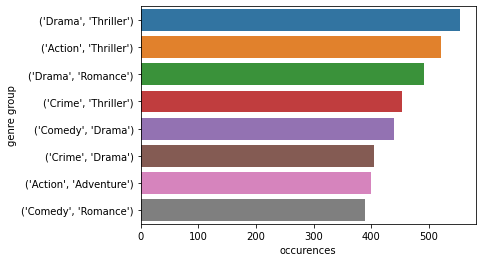

In [30]:
# Display different genre combinations and their frequencies
genres_combination = genre_sub_frame.groupby('index').genres.agg(lambda x: list(itertools.combinations(x,2)))\
                              .explode().value_counts()[:8]
genre_group_bar_plot = sns.barplot(y = genres_combination.index, 
            x = genres_combination.values, 
            orient='h')
genre_group_bar_plot.set(xlabel='occurences', ylabel='genre group')

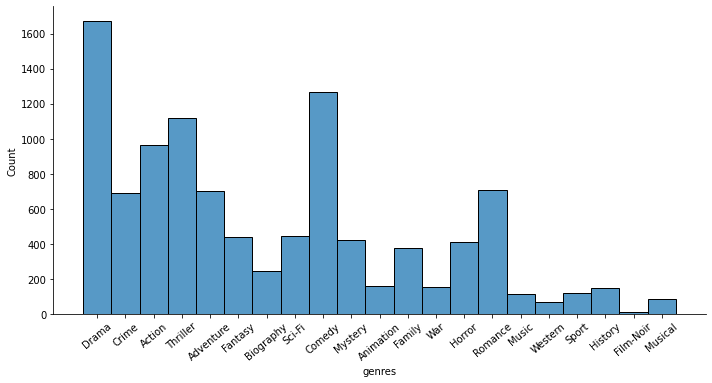

In [31]:
# Display 'genres' distribution
genre_dist_plot = sns.displot(genre_sub_frame, x='genres', height=5, aspect=10/5)
genre_dist_plot.set_xticklabels(rotation=40)

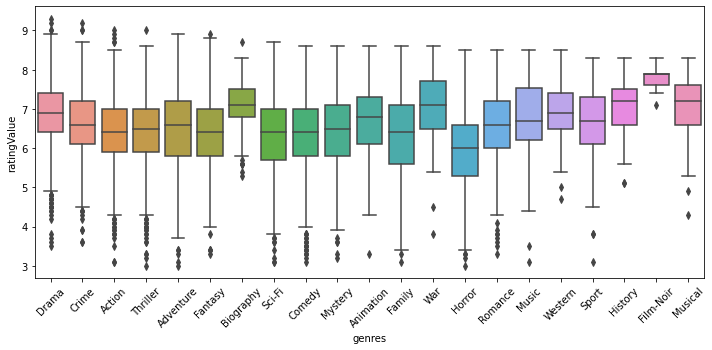

In [32]:
# Display box plot

fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)
genre_box_plot = sns.boxplot(x='genres', y='ratingValue', data=genre_sub_frame)
genre_box_plot = genre_box_plot.set_xticklabels(genre_box_plot.get_xticklabels(), rotation=45)

In [33]:
# Calculate correlation ratio between 'genres' and 'ratingValue'
cr = correlation_ratio(genre_sub_frame['genres'], genre_sub_frame['ratingValue'])
print(f"Correlation ratio between ['genres'] and ['ratingValue'] is {cr}")

Correlation ratio between ['genres'] and ['ratingValue'] is 0.07863589472262483
